# Introduction

## Data Challenge: Large Scale Machine Learning

### Authors: 
#### Charlotte Laclau (charlotte.laclau@telecom-paris.fr), Awais Hussain SANI, Stephan Clémençon

# Image Classification:

Image classification is the task of assigning to an image a label from a predefined set of
categories. A CNN [1] is intended to identify visual forms from images with least computation [2]. In the last few years, we saw a rapid progress in visual image processing systems, mostly due to advances of deep convolutional neural networks.



1. Y. LeCun, L. Bottu, Y. Bengio, Gradient-based learning applied to document recognition, Proceedings of the
IEEE 86 (11) (1998) 2278–2324, https://doi.org/10.1109/5.726791.
2. Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, Imagenet classification with deep convolutional neural net-works, in: NIPS’12 Proceedings of the 25th InternationalConference on Neural Information ProcessingSystem,
vol. 1, 2012, pp. 1097–1105, arXiv:1311.2901.

# The properties of the dataset:

The data set is provided by IDEMIA, a multinational security company with headquaters in France. It consistst of images of faces of different persons with certain characteristics. The task is to train a model able to predict whether certain image possess required chacteristics (encoded by the output labels) or not.
There is imbalance between the sample images in the dataset for men and women.

### Downloading the Data: 

You can download the Dataset from the below link: 
https://partage.imt.fr/index.php/s/MQBgK6fkB8oyWA9

After unzipping the file, you have two folders: train, test and one text files relating to the train labels. You can use training images for training your model.

### Training Data

***Training Data:*** The "train" folder contains 192,576 face images numbered from 000000 to 192,575. These are color images in .jpg format with size of 80x80 pixels.

***Training Labels:*** The file named "label_train.txt" contains three columns. The first column containts the image name and the 2nd column lists the 192,576 labels (-1 or 1) that are used to train your model. The third columns lists the corresponding binary representation of genders (-1: woman, 1: Man)

### Test Data

 The "test" folder contains 9,999 face images numbered from 000000 to 009998. These are color images in .jpg format with size of 80x80 pixels.

### Remarks

 Image classification with certian unknown characteristics are difficult task. The purpose of this data challenge is to train the students to extract different characteristicts from images. So, it is important that at the end of the data challenge, you know the characteristics of the images on which this dataset is based on.

### The Performance Criterion:

You should submit a file that contains in each row classificaiton of images available in **test** folder. For a sample submission please see the codes below. 
To measure the performance of your model, we calculate two parameters.

1- Global Classification Performance  

2- Absolute_value(Classification_Performance_Men - Classification_Performance_Women)

The final metric is then the average classification accuracy for men and women, to which we substractthe difference of classification accuracy between men and women. 
$$ mean(accuracy_{men}, accuracy_{women}) - abs(accuracy_{men} - accuracy_{women})$$

### Example Submission

In [32]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.image as img
import numpy as np
import cv2 as cv

import os
os.getcwd()

%matplotlib inline

In [33]:
labels = pd.read_csv('./data_challenge/train.txt', sep = '\t', header = None, names = ['image','label', 'genre'])
labels = labels.astype({"label": int, "genre": int})
print(labels['label'].value_counts()/len(labels))
labels['label'] = labels['label'].map(lambda x: 0 if x == -1 else x)

# labels = df_labels.iloc[:, 0:2]
submission = pd.read_csv('./data_challenge/test.txt', sep = '\t', header = None, names = ['image'], dtype={'image': str})

train_path = './data_challenge/train/'

test_path = './data_challenge/test/'

-1    0.807136
 1    0.192864
Name: label, dtype: float64


In [34]:
labels.tail()

,image,label,genre
192571,192571.jpg,1,1
192572,192572.jpg,0,1
192573,192573.jpg,0,-1
192574,192574.jpg,0,1
192575,192575.jpg,0,-1


In [35]:
labels['label'].value_counts()

0    155435
1     37141
Name: label, dtype: int64

In [36]:
img_1 = cv.imread('./data_challenge/train/000003.jpg')
print('shape of the image {}'.format(img_1.shape))
print('Value of the pixel {}'.format(img_1[40,40]))

shape of the image (80, 80, 3)
Value of the pixel [ 61  82 133]


192546.jpg
192554.jpg
192558.jpg
192563.jpg
192571.jpg


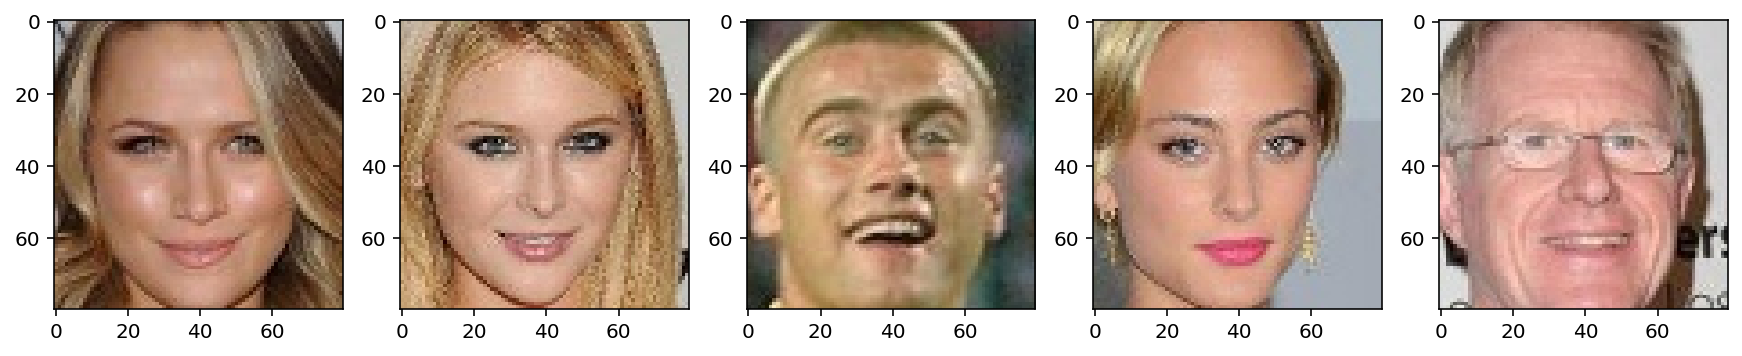

In [37]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['label'] == 1]['image'][-5:]):
    print(idx)

    path = os.path.join(train_path,idx)

    ax[i].imshow(img.imread(path))

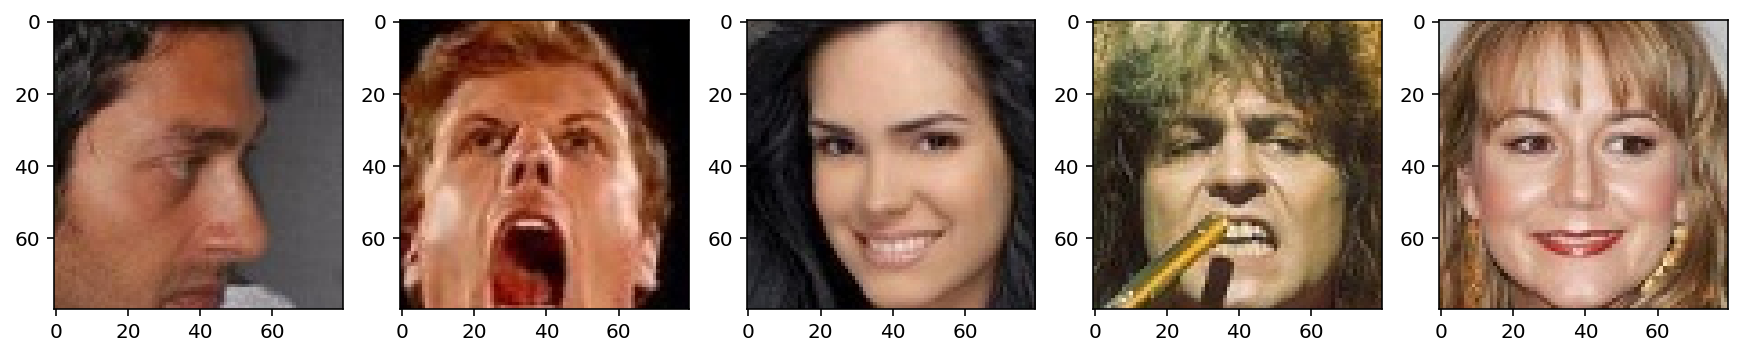

In [38]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['label'] == 0]['image'][-5:]):

    path = os.path.join(train_path,idx)

    ax[i].imshow(img.imread(path))

In [39]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [40]:
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        img_name,label, _ = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [41]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [42]:
# train, valid_data = train_test_split(labels, stratify=labels.label, test_size=0.2)
train, valid_data_df = train_test_split(labels , stratify=labels.label, test_size=0.2)

In [43]:
valid_data_df.head()

,image,label,genre
162291,162291.jpg,0,1
165021,165021.jpg,0,-1
96206,096206.jpg,0,-1
59178,059178.jpg,1,1
156270,156270.jpg,0,1


In [44]:
train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data_df, train_path, valid_transform )


In [45]:
# Hyper parameters
num_epochs = 5
num_classes = 2
batch_size = 25
batch_size_val = 1
learning_rate = 0.001

In [46]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [47]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size_val, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images
torch.Size([3, 80, 80])


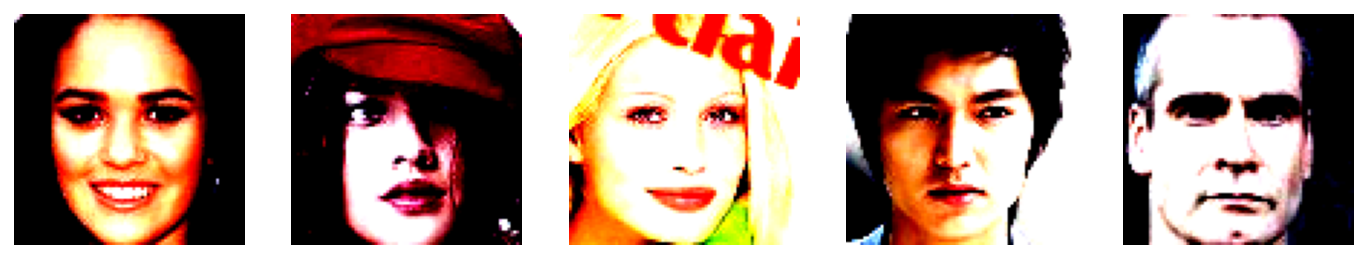

In [48]:
trainimages, trainlabels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)
print(trainimages[0].size())

In [49]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(6480, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [50]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [51]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
    # validate-the-model

    model.eval()

    for data, target in valid_loader:
        data = data.to(device)

        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)

    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(

        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.268795 	Validation Loss: 0.190289
Epoch: 2 	Training Loss: 0.219419 	Validation Loss: 0.175645
Epoch: 3 	Training Loss: 0.207634 	Validation Loss: 0.175514
Epoch: 4 	Training Loss: 0.201293 	Validation Loss: 0.171641
Epoch: 5 	Training Loss: 0.199340 	Validation Loss: 0.166264
CPU times: user 13min 4s, sys: 8.1 s, total: 13min 12s
Wall time: 13min 2s


In [52]:
val_pred_values = []
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, actual_labels in valid_loader:
        images = images.to(device)
        actual_labels = actual_labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_pred_values.append(predicted.item())
        # print(predicted.item())
    #     total += actual_labels.size(0)
    #     correct += (predicted == actual_labels).sum().item()
    # print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 

torch.save(model.state_dict(), 'model.ckpt')

In [53]:
len(val_pred_values)

38516

In [54]:
valid_data_df['score'] = np.array(val_pred_values)
group_by_genre = valid_data_df.groupby('genre')
genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]
genre_0

/home/asani/anaconda3/envs/Data_Challenge_Env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image,label,genre,score
165021,165021.jpg,0,-1,0
96206,096206.jpg,0,-1,0
164238,164238.jpg,1,-1,1
165534,165534.jpg,1,-1,1
128310,128310.jpg,0,-1,0
...,...,...,...,...
152372,152372.jpg,1,-1,1
162763,162763.jpg,0,-1,0
174966,174966.jpg,1,-1,1
63751,063751.jpg,0,-1,0


In [55]:
genre_1

,image,label,genre,score
162291,162291.jpg,0,1,0
59178,059178.jpg,1,1,1
156270,156270.jpg,0,1,0
117486,117486.jpg,1,1,1
52156,052156.jpg,0,1,0
...,...,...,...,...
53530,053530.jpg,0,1,0
91185,091185.jpg,0,1,0
45526,045526.jpg,0,1,0
172498,172498.jpg,0,1,0


In [56]:
print('Accuracy_score: ' , accuracy_score(valid_data_df['label'], valid_data_df['score']))
print('Accuracy_score genre_0: ' , accuracy_score(genre_0['label'], genre_0['score']))
print('Accuracy_score genre_1: ' , accuracy_score(genre_1['label'], genre_1['score']))

Accuracy_score:  0.9333523730397757
Accuracy_score genre_0:  0.9116305839642272
Accuracy_score genre_1:  0.9641534308493942


In [57]:
#Score used for ranking the submission 
score_0 =  accuracy_score(genre_0['label'], genre_0['score'])
score_1 =  accuracy_score(genre_1['label'], genre_1['score'])
print('Final_score:', (score_0+score_1)/2 - abs(score_0-score_1))

Final_score: 0.8853691605216437


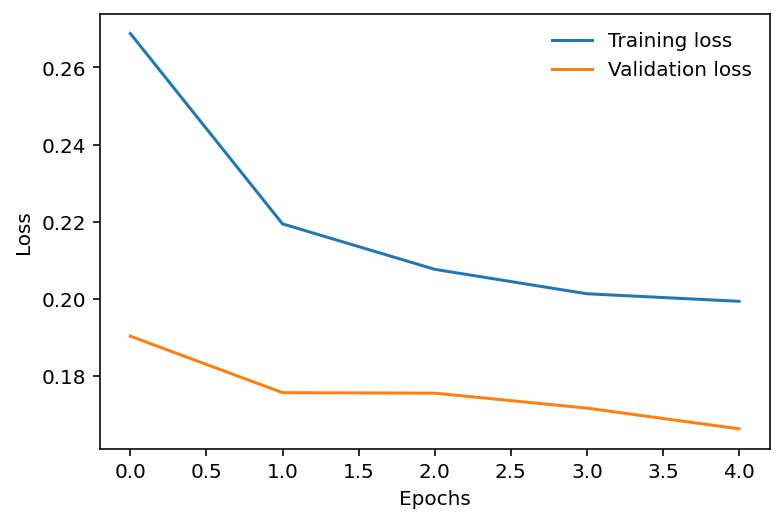

In [58]:
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

### Testing your Model

In [59]:
batch_size_test= 1

class Dataset_test(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values.flatten()
        # print(self.data)
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        img_name = self.data[index]
        img_path = os.path.join(self.path, str(img_name))
        # print(img_path)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image
    
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_data = Dataset_test(submission, test_path, test_transform )
test_loader = DataLoader(dataset = test_data, batch_size = batch_size_test, shuffle=False, num_workers=0)

In [60]:
# test-the-model

model.eval()  # it-disables-dropout
predicted_values = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        # labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # print(predicted.item())
        predicted_values.append(predicted.item())

In [61]:
print(len(predicted_values))
predicted_values[:10]

9999


[1, 0, 0, 0, 1, 0, 0, 0, 1, 0]

### Preparing your file for Submission

In [62]:
results=pd.DataFrame(predicted_values, columns= ['score'])
results['score'] = results['score'].map(lambda x: -1 if x == 0 else x)
results.to_csv("Data_Challenge_MDI_341.csv", header = None, index = None)

#### Now it's your turn. Good luck !  :) 